In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

from astropy.io import fits
import scipy
import pymaster as nmt

In [3]:
f0, f1 = '143', '143'
split0, split1 = '2', '1'

lmax = 2508
nside = 2048
lmax_beam = 3*nside # beam needs to extend to high enough ell for NaMaster

I wrote this awful function to test the low ell binning, it has very minor effects and I should just add the bins manually. It basically adds the bins 2-30 with some width.

In [4]:
def get_bonus_bins(width=5, top_ell=30, l_min=2):
    bonus_bin_left, bonus_bin_right = [], []
    counter = 0
    for i in list(range(1,top_ell))[::-1]:
        counter += 1
        if counter % width == 0:
            bonus_bin_left.append(i)
            bonus_bin_right.append(i+width-1)
        elif i == l_min:
            bonus_bin_left.append(i)
            bonus_bin_right.append(width-1)
    return bonus_bin_left[::-1], bonus_bin_right[::-1]

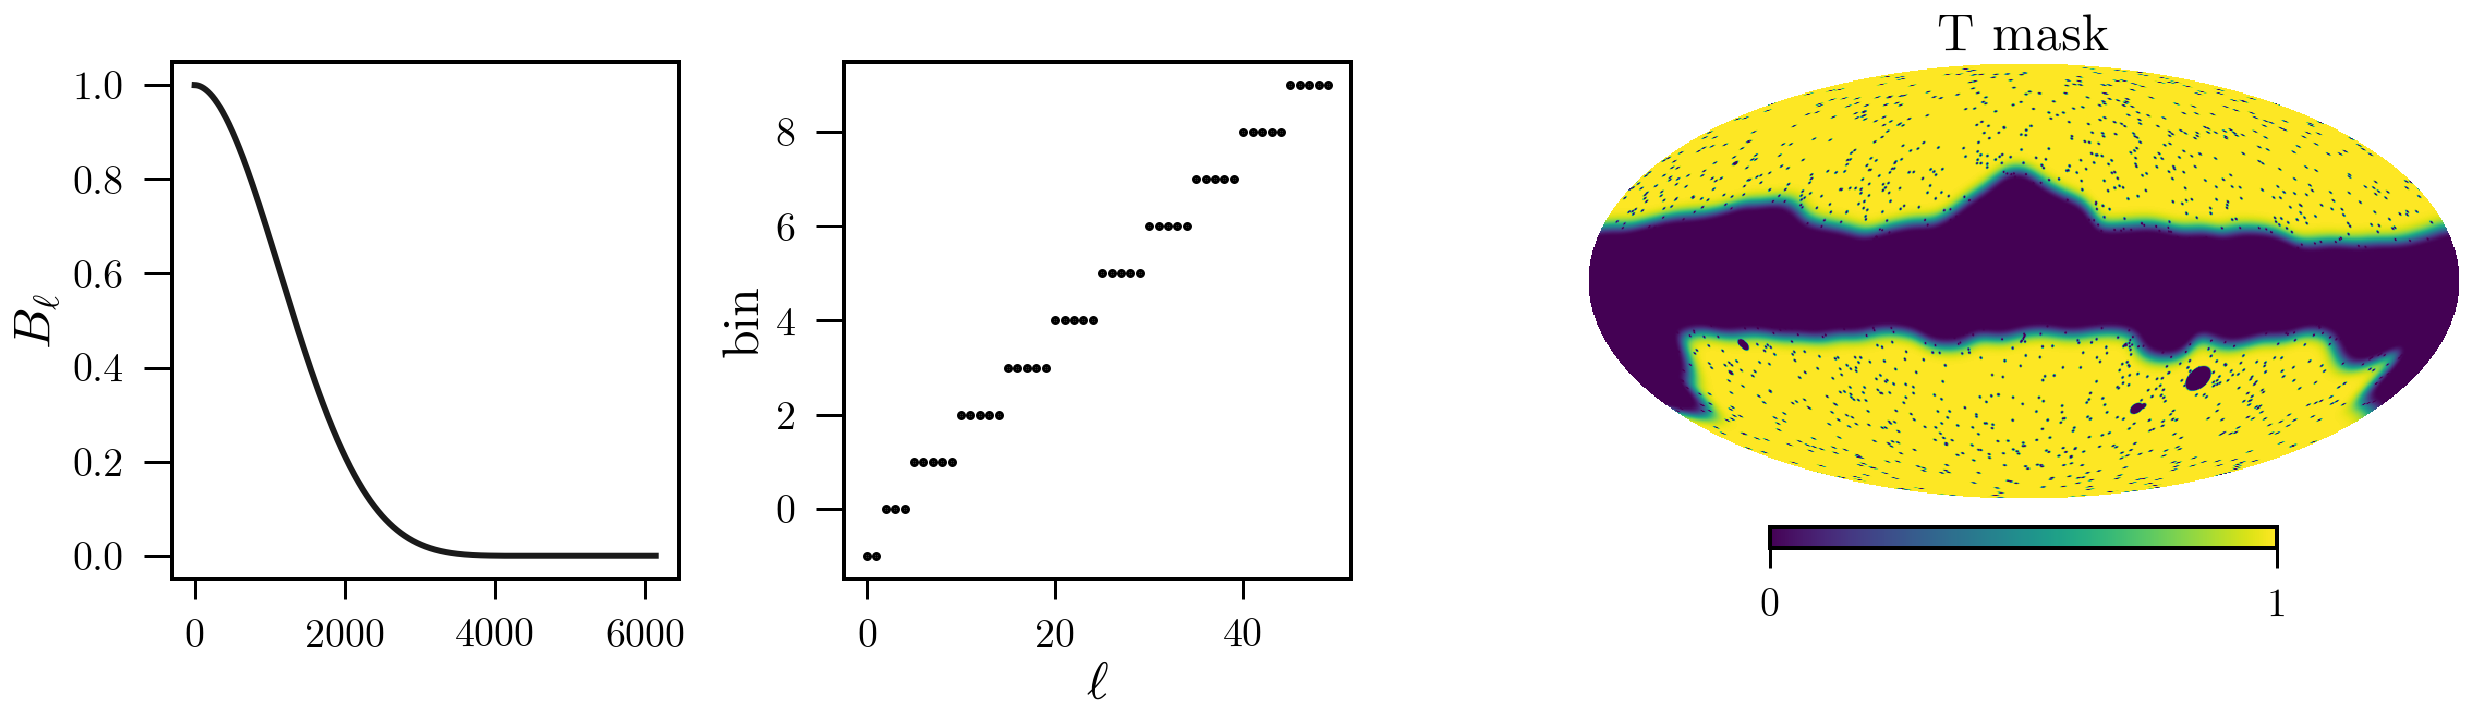

In [5]:
beam_filename = f'planck_beam/beam_likelihood_{f0}hm1x{f1}hm2.dat'
beam_ell, beam = np.genfromtxt(beam_filename, unpack=True) # beam file is ell, Bl
Bl = np.zeros(lmax_beam)
Bl[beam_ell.astype(int)] = beam

binleft, binright = np.genfromtxt('planck_spectra/binused.dat', 
                                  unpack=True, usecols=(0,1), dtype=((int), (int)))
bonus_left, bonus_right = get_bonus_bins(5, l_min=2)
binleft, binright = np.hstack((bonus_left,binleft)), np.hstack((bonus_right,binright))
    
ells = np.arange(lmax+1)
bpws = -1+np.zeros_like(ells) #Array of bandpower indices
for i, (bl, br) in enumerate(zip(binleft, binright)):
    bpws[bl:br+1] = i
weights = np.array([1 for l in ells])
b = nmt.NmtBin(nside, bpws=bpws, ells=ells, weights=weights, lmax=lmax, is_Dell=False)
lb = b.get_effective_ells()

mask0t = hp.read_map(f'masks/COM_Mask_Likelihood-temperature-{f0}_2048_R2.00.fits', verbose=False)
mask0p = hp.read_map(f'masks/COM_Mask_Likelihood-polarization-{f0}_2048_R2.00.fits', verbose=False)
mask1t = hp.read_map(f'masks/COM_Mask_Likelihood-temperature-{f1}_2048_R2.00.fits', verbose=False)
mask1p = hp.read_map(f'masks/COM_Mask_Likelihood-polarization-{f1}_2048_R2.00.fits', verbose=False)

mask0 = [mask0t, mask0p, mask0p]
mask1 = [mask1t, mask1p, mask1p]

fig, ax = plt.subplots(1, 3, figsize=(18,5), gridspec_kw = {'width_ratios':[1, 1, 2]})
ax[0].plot( np.arange(lmax_beam), Bl)
ax[0].set_ylabel(r"$B_{\ell}$")
ax[1].plot(bpws[:50], 'k.')
ax[1].set_ylabel('bin')
ax[1].set_xlabel(r'$\ell$')
fig.tight_layout()

plt.sca(ax[2])
hp.mollview(mask0t, hold=True, title='T mask')

In [6]:
m0_file = f'maps/PR2/frequencyMaps/HFI_SkyMap_{f0}_2048_R2.02_halfmission-{split0}.fits'
m1_file = f'maps/PR2/frequencyMaps/HFI_SkyMap_{f1}_2048_R2.02_halfmission-{split1}.fits'

map0 = [hp.read_map(m0_file, field=0, verbose=False), # I
        hp.read_map(m0_file, field=1, verbose=False), # Q
        hp.read_map(m0_file, field=2, verbose=False)] # U
map1 = [hp.read_map(m1_file, field=0, verbose=False), # I
        hp.read_map(m1_file, field=1, verbose=False), # Q
        hp.read_map(m1_file, field=2, verbose=False)] # U

/home/zequnl/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


I currently compute the bad pixels from the map `II_COV`, `QQ_COV`, `UU_COV`, looking for the healpix missing pixel value.

In [7]:
def load_bad_pix(freq, split):
    mfile = f'maps/PR2/frequencyMaps/HFI_SkyMap_{freq}_2048_R2.02_halfmission-{split}.fits'
    II_COV = hp.read_map(mfile, field=4, verbose=False)
    QQ_COV = hp.read_map(mfile, field=5, verbose=False)
    UU_COV = hp.read_map(mfile, field=6, verbose=False)

    badT = II_COV < -1e30
    badP = np.logical_or.reduce( 
        (II_COV < -1e30, QQ_COV < -1e30, UU_COV < -1e30) )
    return (badT, badP, badP)

badpix0 = load_bad_pix(f0, split0)
badpix1 = load_bad_pix(f1, split1)

map0 = [ (~bp).astype(float) * m for m, bp in zip(map0, badpix0) ]
map1 = [ (~bp).astype(float) * m for m, bp in zip(map1, badpix1) ]

We discovered it was important to subtract the monopole to get the temperature power spectrum right.

In [8]:
def subtract_mono_di(map_in, mask_in):
    map_masked = hp.ma(map_in)
    map_masked.mask = (mask_in<1)
    mono, dipole = hp.pixelfunc.fit_dipole(map_masked)
    m = map_in.copy()
    npix = hp.nside2npix(nside)
    bunchsize = npix // 24
    bad = hp.UNSEEN
    for ibunch in range(npix // bunchsize):
        ipix = np.arange(ibunch * bunchsize, (ibunch + 1) * bunchsize)
        ipix = ipix[(np.isfinite(m.flat[ipix]))]
        x, y, z = hp.pix2vec(nside, ipix, False)
        m.flat[ipix] -= dipole[0] * x
        m.flat[ipix] -= dipole[1] * y
        m.flat[ipix] -= dipole[2] * z
        m.flat[ipix] -= mono
    return m

map0 = [subtract_mono_di(m, mask)
    for m, mask in zip(map0, mask0)]
map1 = [subtract_mono_di(m, mask)
    for m, mask in zip(map1, mask1)]

In [10]:
# pixel_window = hp.sphtfunc.pixwin(nside, pol=False)[:len(Bl)]
# np.save('pixwin2048', pixel_window)
pixel_window = np.load('pixwin2048.npy')

In [11]:
niter = 0

f0t = nmt.NmtField(mask0t, [map0[0]], beam=(Bl*pixel_window), n_iter=niter)
f1t = nmt.NmtField(mask0t, [map1[0]], beam=(Bl*pixel_window), n_iter=niter)

f0p = nmt.NmtField(mask0p,[map0[1], map0[2]], beam=(Bl*pixel_window), n_iter=niter)
f1p = nmt.NmtField(mask1p,[map1[1], map1[2]], beam=(Bl*pixel_window), n_iter=niter)

w0=nmt.NmtWorkspace()
w0.compute_coupling_matrix(f0t,f1t, b, n_iter=niter)
w1=nmt.NmtWorkspace()
w1.compute_coupling_matrix(f0t,f1p, b, n_iter=niter)
w2=nmt.NmtWorkspace()
w2.compute_coupling_matrix(f0p,f1p, b, n_iter=niter)

def compute_master(f_a,f_b,wsp) :
    cl_coupled=nmt.compute_coupled_cell(f_a,f_b)
    cl_decoupled=wsp.decouple_cell(cl_coupled)
    return cl_decoupled


In [12]:
Cb_namaster={}
Cb_namaster['TT']=compute_master(f0t,f1t,w0)[0]
spin1=compute_master(f0t,f1p,w1)
Cb_namaster['TE']=spin1[0]
Cb_namaster['TB']=spin1[1]
Cb_namaster['ET']=Cb_namaster['TE']
Cb_namaster['BT']=Cb_namaster['TB']
spin2=compute_master(f0p,f1p,w2)
Cb_namaster['EE']=spin2[0]
Cb_namaster['EB']=spin2[1]
Cb_namaster['BE']=spin2[2]
Cb_namaster['BB']=spin2[3]

In [13]:
Cb_namaster2={}

spin1=compute_master(f1t,f0p,w1)
Cb_namaster2['TE']=spin1[0]
Cb_namaster2['TB']=spin1[1]
Cb_namaster2['ET']=Cb_namaster2['TE']
Cb_namaster2['BT']=Cb_namaster2['TB']


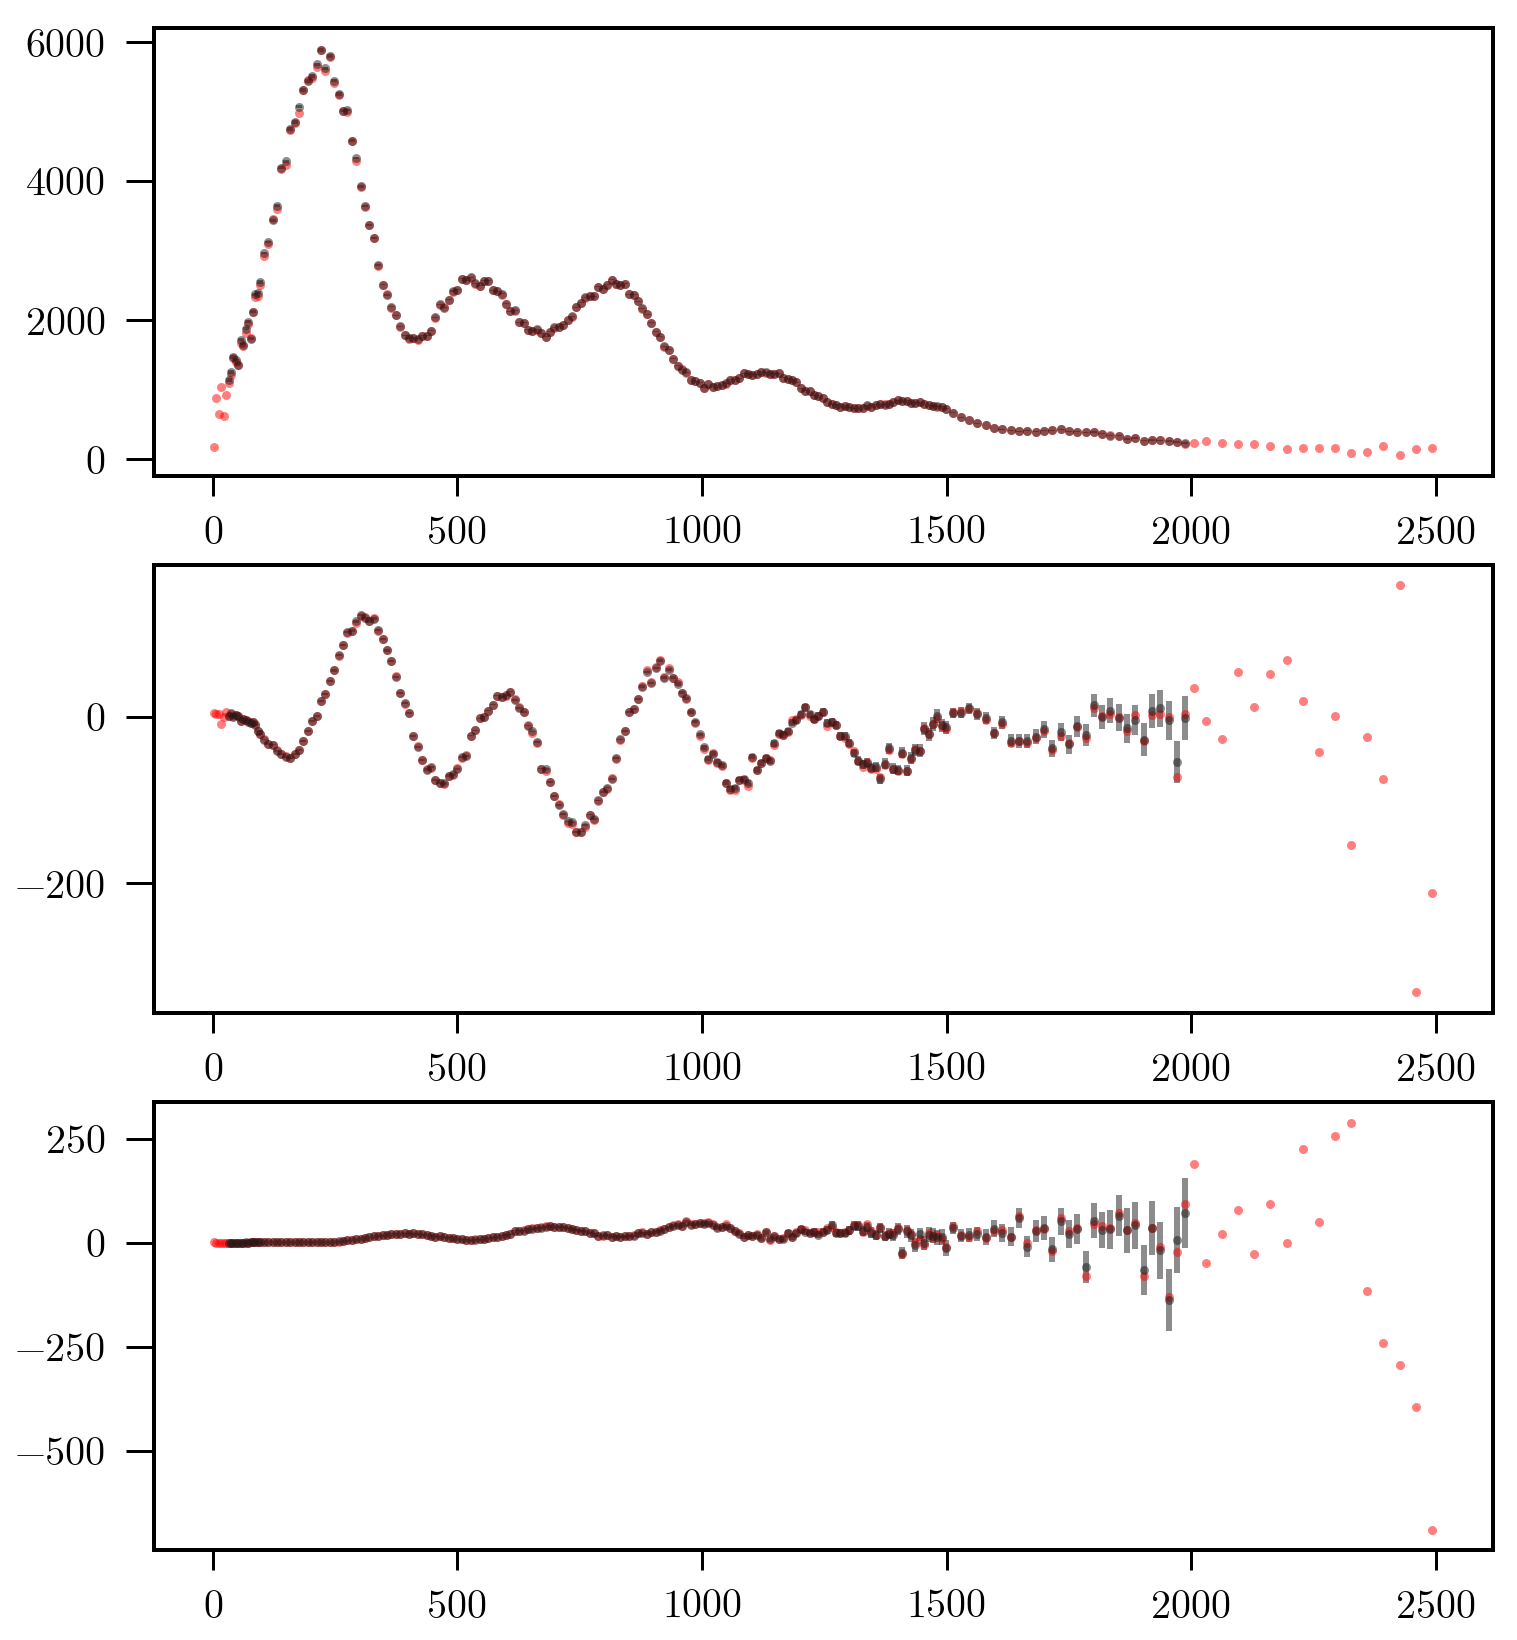

In [14]:
fig, axes = plt.subplots(3,1,figsize=(12,14))

for spec, ax in zip(['TT', 'TE', 'EE'], axes):
    lmin_,lmax_,l_ref,cl_ref,error_ref=np.loadtxt('planck_spectra/spectra_' + f'{spec}_{f0}x{f1}' + '.dat',unpack=True)
    dl_ref_fac = l_ref*(l_ref+1)/(2*np.pi)
  
    ax.errorbar(l_ref,cl_ref*dl_ref_fac,
                error_ref*dl_ref_fac,
                fmt='.',label='%s'%f'{spec}_{f0}x{f1}', alpha=0.5)
    Cb = Cb_namaster[spec]*1e12
    if spec == 'TE':
        Cb = (Cb_namaster[spec] + Cb_namaster2[spec])*1e12 / 2
    ax.plot(lb, Cb * lb**2 / 2 /np.pi,'r.',label=r"NaMaster", alpha=0.5)

I'm coadding the 12 and 21 crosses for TE, to get a better look at the feature.

Text(0.5, 1.0, '143 x 143')

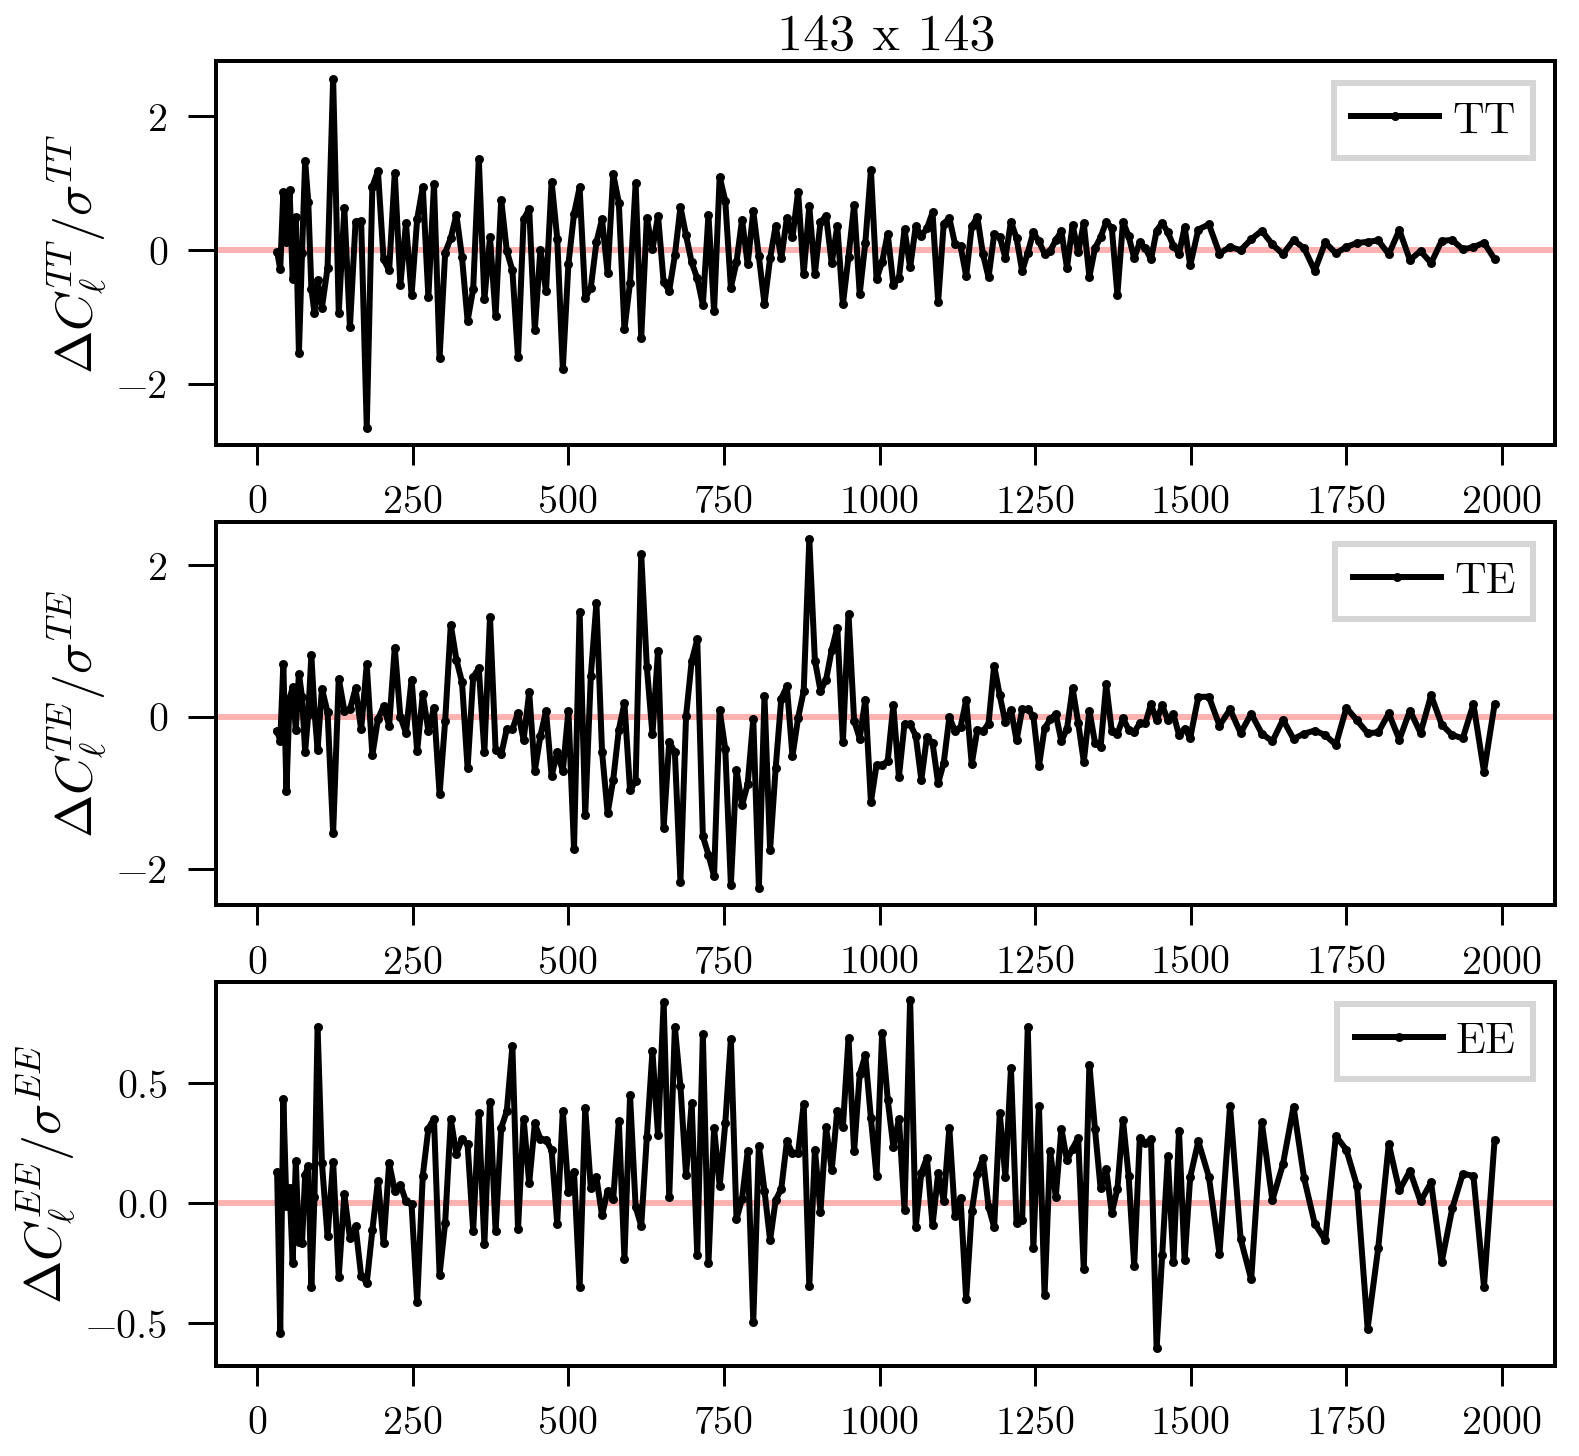

In [15]:
fig, axes = plt.subplots(3,1,figsize=(12,12))

for spec, ax in zip(['TT', 'TE', 'EE'], axes):
    lmin_,lmax_,l,cl,error=np.loadtxt('planck_spectra/spectra_' + f'{spec}_{f0}x{f1}' + '.dat',unpack=True)
    dl_error = error*l*(l+1)/(2*np.pi)
    l_dl = lb[1:199+1]
    
    fp = Cb_namaster[spec]*1e12
    if spec == 'TE':
        fp = (Cb_namaster[spec] + Cb_namaster2[spec])*1e12 / 2
    dl = np.interp(x=l, xp=lb, fp=fp) *l*(l+1)/(2*np.pi)
    dl_ref = cl*l*(l+1)/(2*np.pi)
    
    ax.axhline(0, color='red', alpha=0.3)
    ax.plot( l,(dl - dl_ref) / (error*l*(l+1)/(2*np.pi)), 'k.-', label=spec)

    ax.legend(frameon=True, fancybox=False)
    ax.set_ylabel(r'$\Delta C_{\ell}^{' + spec + r'} / \sigma^{'  + spec + r'}$')
#     plt.yscale('log')

axes[0].set_title(f'{f0} x {f1}')